In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression as LR

In [141]:
frame = pd.read_csv('SPB/1min/OIS.csv', sep=';', header=None)
frame.columns = ('DATE','OPEN','HIGH','LOW','CLOSE','VOL','d')
frame = frame.drop('d',axis=1,)
transform_date = lambda s: datetime.datetime.strptime(s,'%Y-%m-%dT%H:%M:%S')
frame.DATE = frame.DATE.apply(transform_date)
frame['day'] = frame.DATE.apply(lambda x: x.day)
frame['year'] = frame.DATE.apply(lambda x: x.year)
frame['month'] = frame.DATE.apply(lambda x: x.month)
frame['minute'] = frame.DATE.apply(lambda x: x.minute)
frame['hour'] = frame.DATE.apply(lambda x: x.hour)
frame['t'] = frame.minute + 60*frame.hour

frame = frame[(frame.year == 2020) & (frame.month >=2)]

In [139]:
mask = (frame.day == 23) & (frame.month == 4)
fr_day = frame[mask]
# fr_day = fr_day[700:800]

In [4]:
def get_window_from_array(arr,step = 15, window = 15):
    N_step = round(len(arr)/step)
    for k in range(N_step):
        a = arr[k*step:(k+1)*step+(window-step)]
        yield a

In [86]:
def get_window(frame,step, type_='OPEN'):
    shift = 50
    L = len(frame)
    N_step = round(L/step)
    for i in range(N_step):
        Y = frame[type_].values[i*step:(i+1)*step]
        X = frame.index[i*step:(i+1)*step].values
        
        
        yield X, Y 
        
#     slic = slice( )

def create_model_predict(X,Y):
    model = LR()
    model.fit(X,Y)
    return model.predict(X)

def angle_between_lines(s1, s2):
    """
        return angs: в градусах
    """
    if len(s1) != len(s2):
        return 0
    T = np.arange(0, len(s2)).reshape(-1,1)
    model_1 = LR().fit(T, s1.reshape(-1,1))
    model_2 = LR().fit(T, s2.reshape(-1,1))
    k1 = model_1.coef_[0][0]
    k2 = model_2.coef_[0][0]
    arg = (k2-k1)/(1+k1*k2)
    angle = np.arctan(arg)*180/np.pi # в градусах
    return angle

def write_angles(arr, step, W, shift):
#     file = open('angle.txt', 'w')
    angs = []
    for indx,(s1,s2) in enumerate(zip(get_window_from_array(arr, step, W),
                                      get_window_from_array(arr[shift:], step, W) )):
        angle = angle_between_lines(s1,s2)
        angs.append(angle)
#         file.write("{:.2f}\n".format(angel))
#     file.close()
    return angs

In [6]:
def culculate_delta(arr, step, W, shift, delta_step):
    """
        shift: смещение второй прямой относительно первой
        Возвращает угол и отношение цен(delta) для сдвига(delta_step) c конца интервала
        delta_step: смещение от конца второго интервала
    """
    angs = []
    deltas = []
    for indx,(s1,s2) in enumerate(zip(get_window_from_array(arr, step, W),
                                      get_window_from_array(arr[shift:], step, W) )):
        L = len(arr)
        
        h = indx + W + shift - 1 + delta_step # индекс будущего значения цены для расчета отклонения цен
        t = np.arange(indx, indx + W)        
        angle = angle_between_lines(s1, s2)
        
        if h+1 > L:
            continue
#         print(indx,s1,s2, arr[h-1], arr[h - delta])
        g = (arr[h] - arr[h-delta_step])/arr[h-delta_step]*100
        angs.append(angle)
        deltas.append(g)
    return angs, deltas


def get_index(arr, step, W, shift, lvl):
    """
        delta: смещение от конца второго интервала
    """
    indexs = []
    for indx,(s1,s2) in enumerate(zip(get_window_from_array(arr, step, W),
                                      get_window_from_array(arr[shift:], step, W) )):
        L = len(arr)
        t = np.arange(indx, indx + W)        
        angle = angle_between_lines(s1, s2)
        h = indx+W
        if h+1 > L:
            continue
        if angle > lvl:
            indexs.append(indx)
    return indexs

### Plot functions

In [159]:
def variate_shift_plot(name, arr, shifts,**arg):
    N = int(np.rint(np.sqrt(len(shifts))))
    fig, axes = plt.subplots(N,N,**arg)
    for k in range(N):
        for j in range(N):
            i = k*N+j + 1
            if i > len(shifts) - 1:
                break
            shift = shifts[i]
            angs, deltas =culculate_delta(arr, 1, 30, shift, delta = 15)
            angs = np.array(angs)
            deltas = np.array(deltas)
            axes[k][j].grid()
            axes[k][j].scatter(angs, deltas,s=4)
            axes[k][j].hlines(0,angs.min(), angs.max(),ls='--',     lw=1)
            axes[k][j].vlines(0,deltas.min(), deltas.max(),ls='--', lw=1)
            axes[k][j].set_title(str(shift))
            median = deltas.mean()
            axes[k][j].scatter(0, median,s=7, color='red')

    fig.tight_layout()
    fig.savefig('plt/lines/corner/{}.jpeg'.format(name),bbox_inches = 'tight')

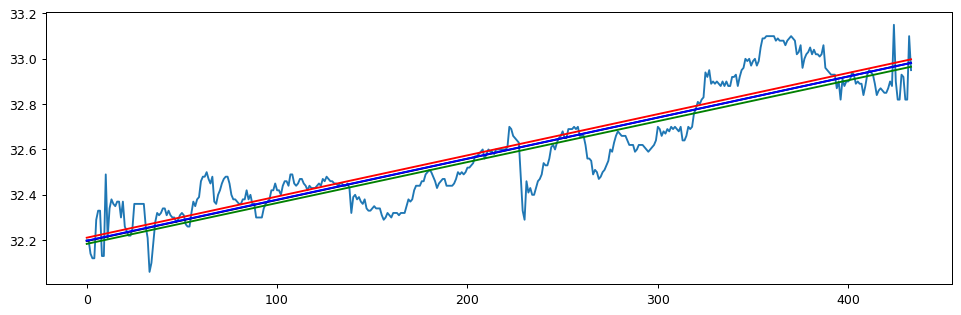

In [7]:
X = fr_day.t.values.reshape(-1,1)
X = np.arange(len(fr_day)).reshape(-1,1)
fig = plt.figure(figsize = (13,4), dpi = 90)

arr = fr_day.OPEN.values
plt.plot(arr)

Y = fr_day.OPEN.values.reshape(-1,1)
y_predict = create_model_predict(X,Y)
plt.plot(y_predict,color='black')

Y = fr_day.HIGH.values.reshape(-1,1)
y_predict = create_model_predict(X,Y)
plt.plot(y_predict,color='red')

Y = fr_day.CLOSE.values.reshape(-1,1)
y_predict = create_model_predict(X,Y)
plt.plot(y_predict,color='blue')

Y = fr_day.LOW.values.reshape(-1,1)
y_predict = create_model_predict(X,Y)
plt.plot(y_predict,color='green')

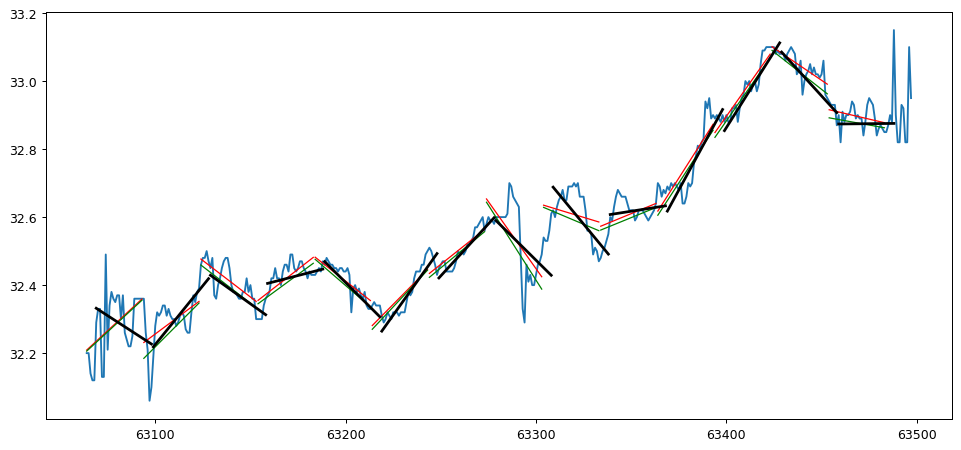

In [8]:
fig = plt.figure(figsize = (13,6), dpi = 90)
arr = fr_day.OPEN.values
plt.plot(fr_day.index, arr)
window = 30
for X,Y in get_window(fr_day, window ):
    predict = create_model_predict(X.reshape(-1,1),Y.reshape(-1,1))
#     print(predict)
    plt.plot(X,predict, color='red', lw=1)
    
for X,Y in get_window(fr_day, window, 'LOW'):
    predict = create_model_predict(X.reshape(-1,1),Y.reshape(-1,1))
#     print(predict)
    plt.plot(X,predict, color='green', lw=1)
    
    
for X,Y in get_window(fr_day[5:], window, 'LOW'):
    predict = create_model_predict(X.reshape(-1,1),Y.reshape(-1,1))
#     print(predict)
    plt.plot(X,predict, color='black',lw=2.2)

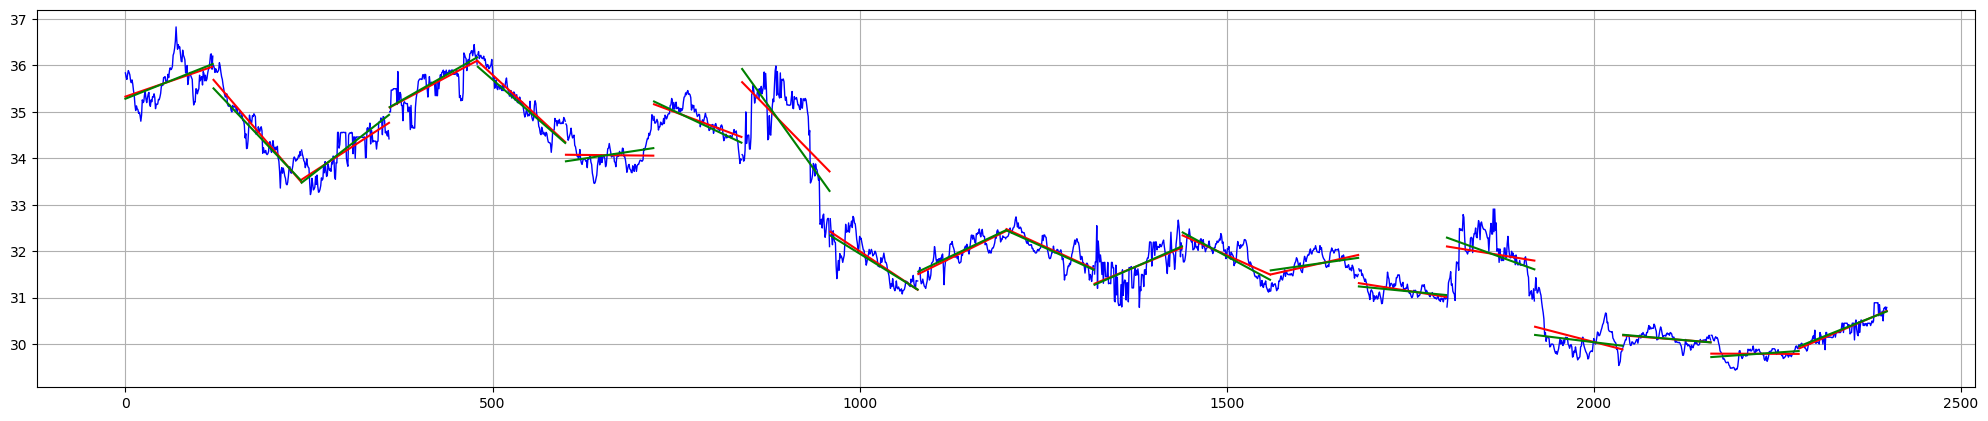

In [9]:
step = 120
W = 120
fig = plt.figure(dpi = 100, figsize=(25,5))
ax = fig.gca()
arr = frame.OPEN.values[13005:15500]
index = 0
for a in get_window_from_array(arr, step, W):
    t = np.arange(index, index+W)
    if len(t) != len(a):
        break
        
    ax.plot(t,a, color='b',linewidth=1)
    predict = create_model_predict(t.reshape(-1,1),a.reshape(-1,1))

    ax.plot(t, predict,'red')
    index +=step
index = 0 

for a in get_window_from_array(arr[5:], step, W):
    t = np.arange(index, index+W)
    if len(t) != len(a):
        break
    predict = create_model_predict(t.reshape(-1,1),a.reshape(-1,1))
    ax.plot(t, predict,'green')
    index +=step
ax.grid()

In [10]:
import gc
gc.collect()

5496

In [11]:
len(arr)

2495

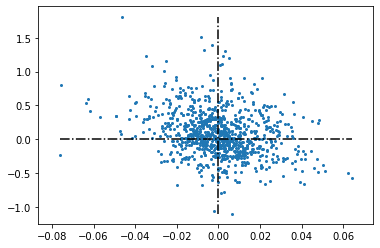

In [96]:
arr = frame.OPEN.values[:1000]
angs, deltas =culculate_delta(arr, 1, 60, 1, delta = 15)
angs = np.array(angs)
deltas = np.array(deltas)
plt.scatter(angs, deltas, s=4)
plt.hlines(0,angs.min(), angs.max(),ls='-.')
plt.vlines(0,deltas.min(), deltas.max(),ls='-.')

In [99]:
len(frame)

49726

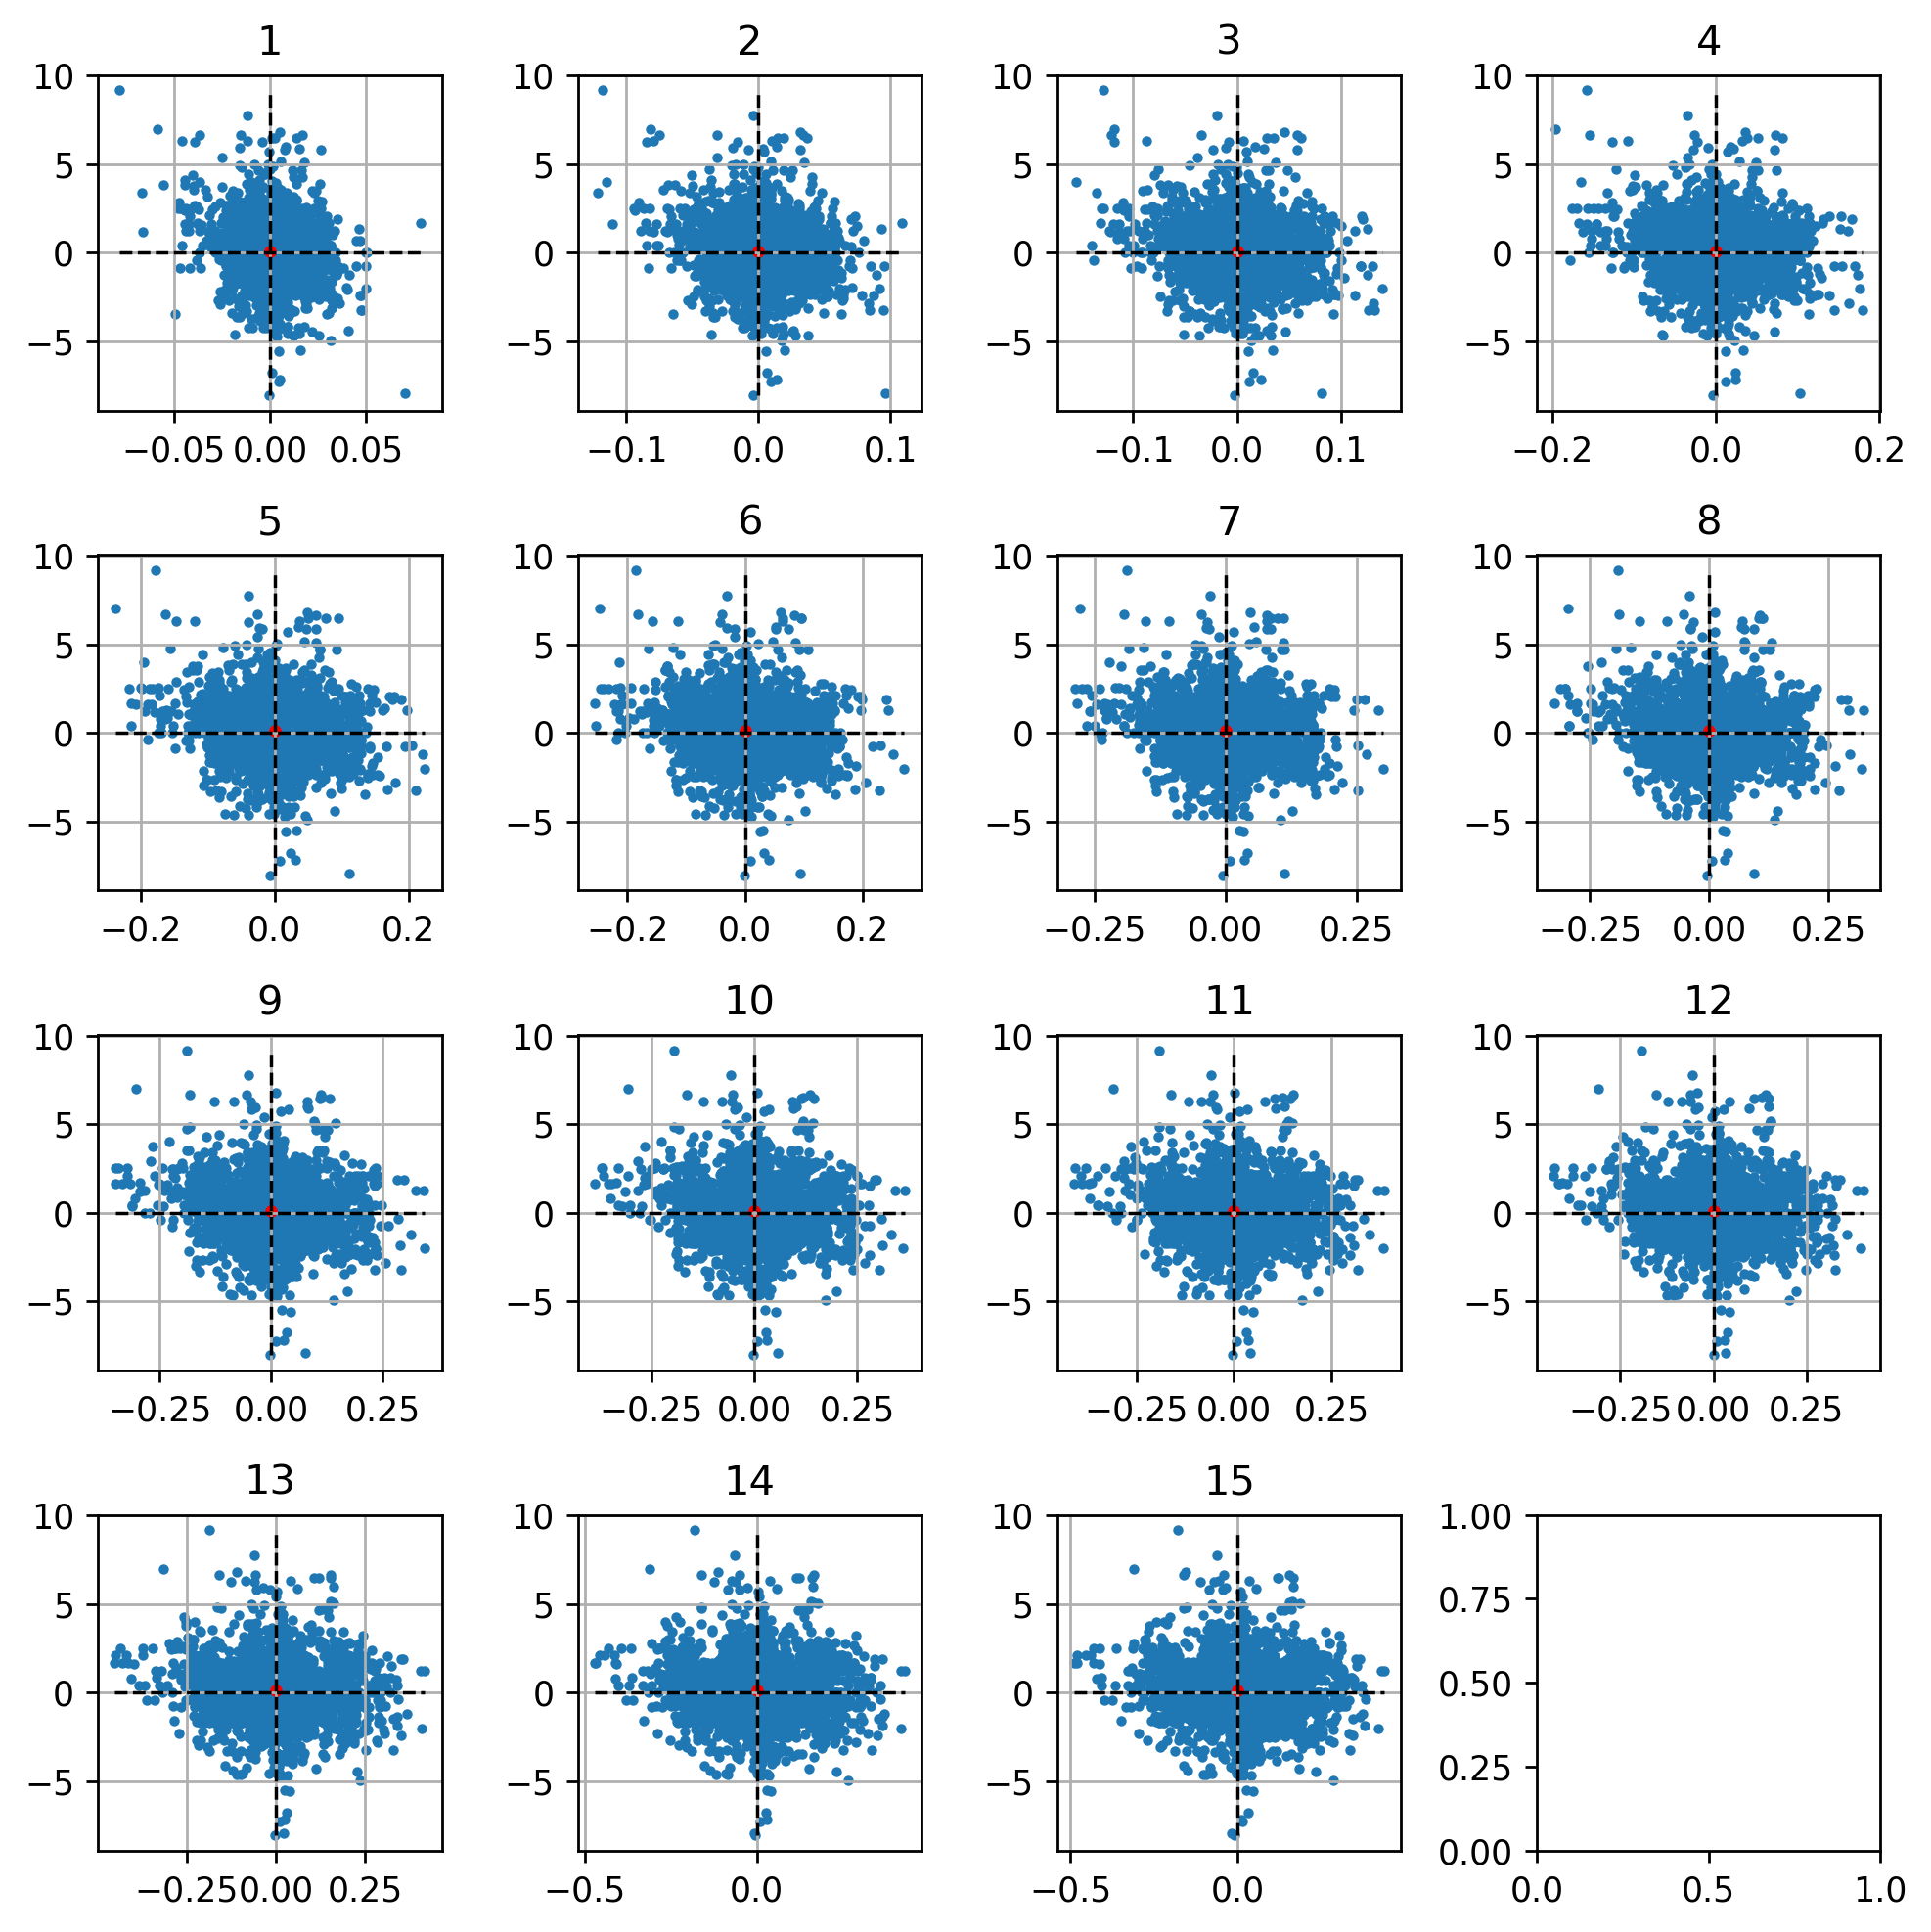

In [145]:
variate_shift('OIS_30', arr = frame.OPEN.values[20000:], shifts = np.arange(0,16),figsize=(8,8), dpi = 250)

In [156]:
arr = frame.OPEN.values[15000:]
indexs = get_index(arr, 1, 100, 5, lvl = 0.03)

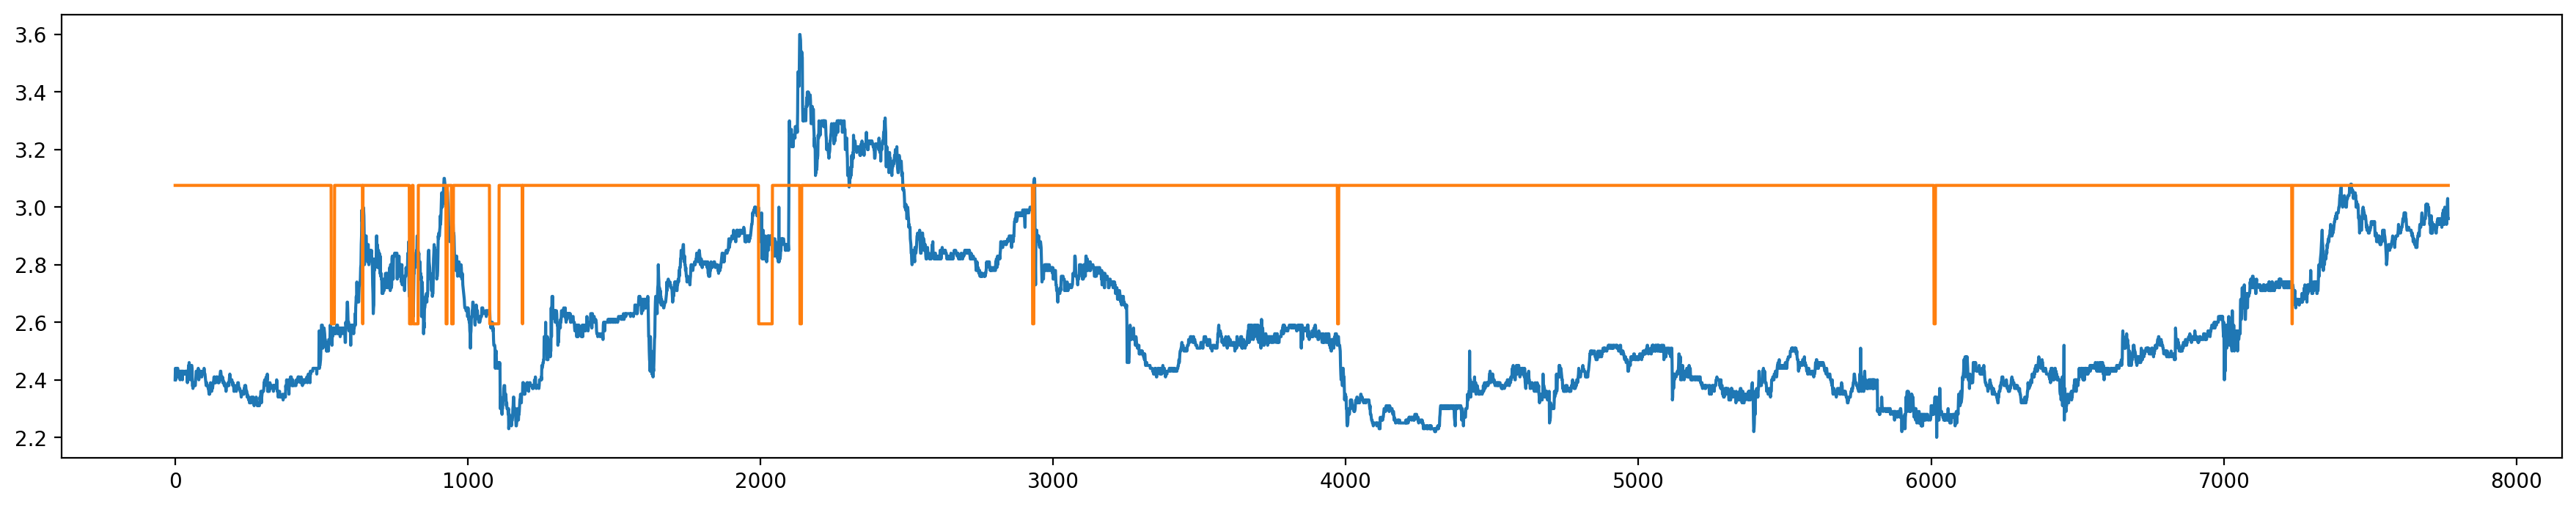

In [157]:
fig = plt.figure(dpi = 200, figsize=(22,4))
plt.plot(arr)
ones = np.ones(len(arr)) + 0.8*arr.mean()
ones[indexs] = arr.mean()
plt.plot(ones)

In [155]:
len(arr)

2768

In [ ]:
step = 5
W = 80
shift = 15
fig = plt.figure(dpi = 100, figsize=(15,10))
ax = fig.gca()
arr = frame.OPEN.values[16005:19000]
arr = frame.OPEN.values[19005:21000]

ax.plot(arr,color='b')
ax.grid()

index = 0
for s1, s2 in zip(get_window_from_array(arr, step, W),get_window_from_array(arr[shift:], step, W)):
    fig = plt.figure(dpi = 100, figsize=(23,5))
    ax = fig.gca()
#     arr = frame.OPEN.values[13005:13500]
    ax.plot(arr,color='b')
    ax.grid()
    
    t = np.arange(index, index+W)
    if len(t) != len(s1) != len(s2):
        break
    predict = create_model_predict(t.reshape(-1,1), s1.reshape(-1,1))
    ax.plot(t, predict,'red')
    
    predict = create_model_predict(t.reshape(-1,1), s2.reshape(-1,1))
    ax.plot(t, predict,'green')
    
    #+1 min
    angl = angle_between_lines(s1,s2)
    ax.set_title(str(angl))
    index +=step
    fig.set_constrained_layout_pads(w_pad=0., h_pad=0.,
        hspace=0., wspace=0.)
    fig.savefig('plt/lines/1/stock_'+str(index)+'.jpeg',pad_inches=0, bbox_inches='tight')
    plt.close('all')
    plt.tight_layout()
    if index%200==0:
        print(index)
    del ax,fig,s1,s2
    gc.collect()
    

In [200]:
gen = get_window_from_array(arr[:210],1, 30)
for s in gen:
    angl = angle_between_lines(s, np.zeros((len(s),1)))
    angl_1 = angle_between_lines(s, np.zeros((len(s),1))+ s.mean())
    print('%.3f %.3f'%(angl,angl_1))

-0.000 -0.000
0.012 0.012
0.008 0.008
0.020 0.020
0.021 0.021
0.014 0.014
0.006 0.006
0.002 0.002
0.006 0.006
-0.002 -0.002
-0.010 -0.010
-0.007 -0.007
-0.010 -0.010
0.009 0.009
0.004 0.004
-0.000 -0.000
-0.004 -0.004
-0.012 -0.012
-0.004 -0.004
-0.018 -0.018
-0.020 -0.020
-0.022 -0.022
-0.024 -0.024
-0.015 -0.015
-0.025 -0.025
-0.035 -0.035
-0.032 -0.032
-0.040 -0.040
-0.047 -0.047
-0.051 -0.051
-0.027 -0.027
-0.005 -0.005
0.020 0.020
0.036 0.036
0.051 0.051
0.062 0.062
0.072 0.072
0.088 0.088
0.096 0.096
0.106 0.106
0.115 0.115
0.115 0.115
0.111 0.111
0.115 0.115
0.104 0.104
0.097 0.097
0.089 0.089
0.074 0.074
0.065 0.065
0.044 0.044
0.027 0.027
0.014 0.014
0.012 0.012
0.010 0.010
-0.008 -0.008
-0.026 -0.026
-0.049 -0.049
-0.072 -0.072
-0.096 -0.096
-0.112 -0.112
-0.109 -0.109
-0.098 -0.098
-0.081 -0.081
-0.076 -0.076
-0.069 -0.069
-0.062 -0.062
-0.057 -0.057
-0.048 -0.048
-0.042 -0.042
-0.030 -0.030
-0.021 -0.021
-0.014 -0.014
-0.007 -0.007
-0.008 -0.008
-0.005 -0.005
0.005 0.005
0.

In [174]:
np.zeros((10,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [224]:
a = [[1,2,3],[11,12,13],[21,22,23]]
a

[[1, 2, 3], [11, 12, 13], [21, 22, 23]]

In [223]:
a[2:][0]

[21, 22, 23]